# Replication of Inoue (2008)

[Link to the paper](Inoue_efficient_estimation.pdf)

Some notes:
- Considers pseudo-panel models in which the number of groups and time periods are small relative to the number of individuals per group
- Implements a GMM estimator for the FE model that is more efficient than the regular FE model as estimated using pooled OLS (POLS)
    - GMM should be more efficient than POLS since it is a GLS version of the FE estimator
    - Results in lower RMSE for $\beta$
- He accounts for asymptotics for S,T stable and $N \rightarrow \infty$ (so group size would grow)
    - GMM and OLS both unbiased and consistent, but GMM more efficient
    - Therefore, as group size increases, GMM and OLS should converge to the same value

Problems with the implementation

- The estimator is implemented correctly
    - Yields the same results as verified OLS estimator when GMM weighting matrix equals identity
- However, the RMSE is much lower than in Inoue
    - I did finally fix the bug that led to higher RMSE for GMM :)
- Moreover, RMSE does not decrease as average group size $\bar{N}$ increases
    - Group size refers to the number of observations per cohort (group)
    - One would expect RMSE to become lower for $\bar{N}$ large:
        - Individual-specific regressor $z_{st}$ is averaged over, so the contribution of individual-specific error $\epsilon_{z,i}$ should go to 0.  
    - Possibly an error in the averaging process? Or the specification of the variances?


#### Classes and functions that I use to simulate and estimate the data

These are also implemented in [class_FE_regression.py](class_FE_regression.py), but I include them for completeness. 

The model that we are trying to estimate

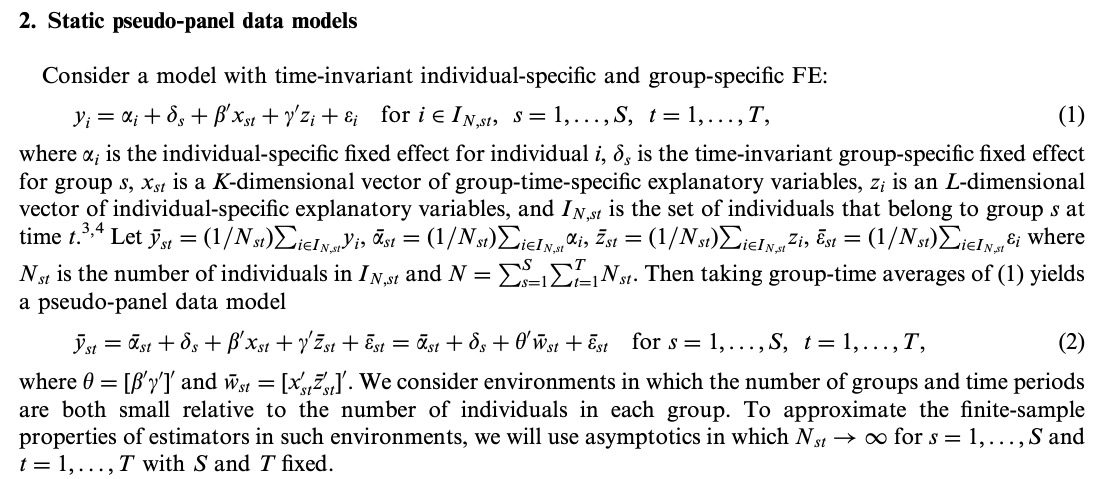

The proposed GMM estimator can be written as 

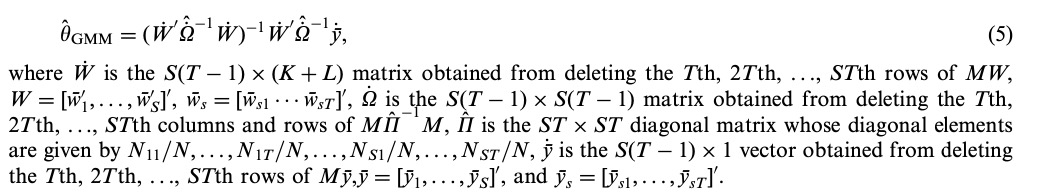

In [77]:
import numpy as np

# Implementation of the simulation study of Inoue (2008), slow
class GMM_replication():

    def simulate(self, S, T, N_bar, var_ds, var_xst, var_zi, var_vzst):
        '''
        Gamma = individual regressor coefficient
        Beta = group regressor coefficient
        S = groups
        T = time periods
        N_bar = average group size
        var_ds = variance of group FE
        var_xst = variance of group regressor
        var_zi = variance of individual regressor + individual error
        var_vzst = variance of individual regressor
        '''
        
        # Convert to SD
        var_ds = np.sqrt(var_ds)
        var_xst = np.sqrt(var_xst)
        var_zi = np.sqrt(var_zi)
        var_vzst = np.sqrt(var_vzst)
        
        # Determining group sizes
        # Pi matrix
        pi_st = np.random.uniform(size = S*T)
        Pi = np.diag(pi_st / pi_st.sum()) # pi_st = ST uniform random variables that sum to one

        group_sizes_vec = np.ceil(np.diag(Pi) * N_bar * S * T).astype(int) # N_st = the smallest integer that is larger than or equal to pi_st*N_bar*S*T
        group_sizes_mat = group_sizes_vec.reshape((S, T))

        var_ai_ei = 1 - var_ds # individual FE + individual error
        var_ezi = var_zi - var_vzst

        # Generate group FE
        d_s = np.random.normal(0, var_ds, S)

        # Generate regressors x, v, iid normal
        x_st = np.random.normal(0, var_xst, S*T)
        v_zst = np.random.normal(0, var_vzst, S)
        
        # Simulate y_i = S*T
        ## Since beta, gamma = 0, the only variation in y_i comes from a_i, d_s, e_i

        y_bar_s = []
        z_bar_st = []

        for s in range(S):
            for t in range(T):
                # y_bar
                d = d_s[s] # FE for group s
                n = group_sizes_mat[s, t]
                ai_ei = np.random.normal(0, var_ai_ei, n)
                # Since beta=0, y=fixed effect + error
                y_bar_s.append(np.mean(ai_ei)+d)
                
                # z_i
                v = v_zst[s]
                z = np.random.normal(0, var_ezi, n)
                z_bar_st.append(np.mean(z) + v)
                
        self.X = np.vstack((x_st, np.array(z_bar_st))).T
        self.Y = y_bar_s
        self.group_sizes_vec = group_sizes_vec
    


    def estimate(self, X, Y, S, T, group_size_vec):
        M = np.kron(np.eye(S), demean(T))
        Ts = np.arange(T-1, S*T, T) # Indices of last time-period, to use in T*N vectors
        
        X1 = M @ X
        X2 = np.delete(X1, Ts, axis = 0)
        
        group_size_mat = np.diag(group_size_vec)
        Omega = M@np.linalg.inv(group_size_mat)@M
        Omega = np.delete(Omega, Ts, axis = 0)
        Omega = np.delete(Omega, Ts, axis = 1)
        
        Omega_inv = np.linalg.inv(Omega)
        
        Y1 = M @ Y
        Y2 = np.delete(Y1, Ts)
        
        coefs = np.linalg.inv(X2.T @ Omega_inv @ X2) @ X2.T @ Omega_inv @ Y2 

        return coefs.tolist()
        
            
    def simulate_estimate(self, S, T, N_bar, var_ds, var_xst, var_zi, var_vzst, reps):
        OLS_coefs, GMM_coefs = [], []
        
        for _ in range(reps):
        
            self.simulate(S, T, N_bar, var_ds, var_xst, var_zi, var_vzst)

            # GMM estimator reduces to OLS with identity weighting matrix
            ## Set group sizes all equal with np.ones()
            OLS_estimate = self.estimate(self.X, self.Y, S, T, np.ones(S*T))
            OLS_coefs.append(OLS_estimate)
            ## Use optimal weighting matrix Pi_hat (this specifies the diagonal of that matrix)
            group_sizes_normalized = self.group_sizes_vec / np.sum(self.group_sizes_vec)
            GMM_estimate = self.estimate(self.X, self.Y, S, T, group_sizes_normalized)
            GMM_coefs.append(GMM_estimate)
            
            
        return [np.array(OLS_coefs), np.array(GMM_coefs)]

def demean(T):
    M_T = np.eye(T) - (1/T) * np.ones((T, T))
    return M_T


#### Simulation/estimation

The parameters are copied from the paper. 

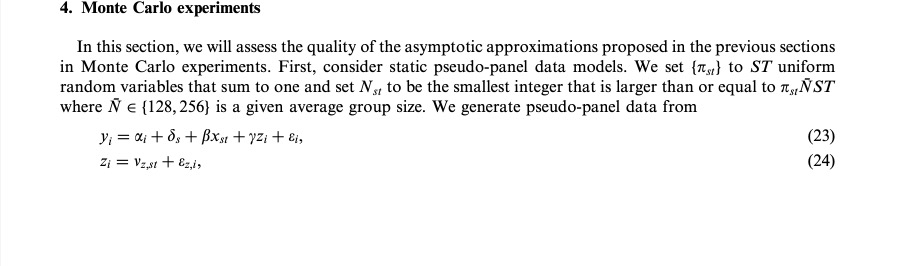
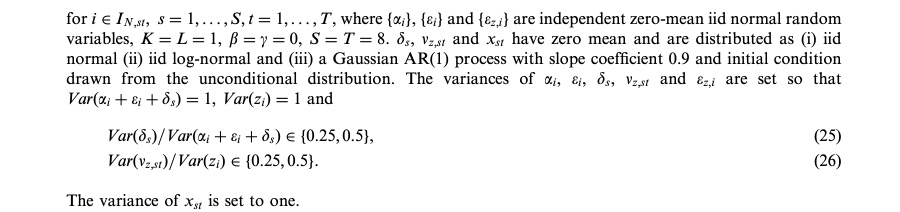

- $Var(\delta_{s})/Var(\alpha_{i}+\varepsilon_{i}+\delta_{s})=0.5$

    $Var(\alpha_i+\varepsilon_i+\delta_s)=1$

    $Var(\delta_{s})/1 = Var(\delta_{s}) = 0.5$


Same for the variance of $v$, 

- $Var(v_{z,st})/Var(z_{i}) = 0.5$

    $Var(z_{i}) = 1$

    $Var(v_{z,st})/1 = Var(v_{z,st}) = 0.5$



In [78]:
# Regressors 
## X_st = iid normal
gamma, beta = 0, 0
# Groups
S, T = 8, 8

# Mean group size
N_bar = 256

# nr of repititions
reps = 1000

# Variances
var_ds = 0.5 # group FE
var_xst = 1 # group regressor variance
var_zi = 1 # individual regressor + individual error variance
var_vzst = 0.5 # individual regressor variance

GMM_class = GMM_replication()

res = GMM_class.simulate_estimate(S, T, N_bar, var_ds, var_xst, var_zi, var_vzst, reps)
# res[0] = estimated coefs for FE OLS, res[1] = estimated coefs for GMM


FE_OLS_MAE = abs(res[0]).mean()
GMM_MAE = abs(res[1]).mean()

FE_OLS_RMSE = np.sqrt(np.square(res[0]).mean())
GMM_RMSE = np.sqrt(np.square(res[1]).mean())


print(f"OLS RMSE: {FE_OLS_RMSE}\nGMM_RMSE: {GMM_RMSE}\nRatio: {GMM_RMSE/FE_OLS_RMSE}")


OLS RMSE: 0.24535912947629163
GMM_RMSE: 0.1022447733848654
Ratio: 0.41671477072445773


Outcome of the simulation in the Inoue paper:

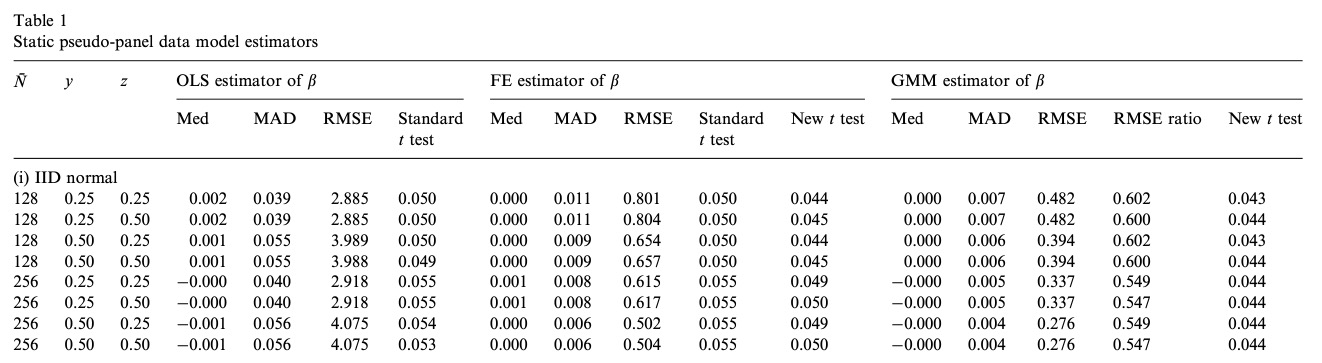